# Noisy Circuits


Author: Alexandra Semposki

Maintainer: Alexandra Semposki

Now that VQE has been extensively covered for a noiseless system, we can begin to consider what happens when we add noise into the circuit. Of course, some questions one would have are how the noise occurs in the circuit, how does it affect the circuit results, and how would one correct such errors? In this notebook, we'll cover all of these questions and end with an error mitigation technique that will become very useful for the calculations in the rest of this Jupyter Book.

## On the origin of noise

If you've only ever run a quantum circuit on a simulator, you've probably never encountered errors on your qubits (unless you were using a noisy backend, of course). However, if you run your circuit(s) on a real quantum device, like IBM's quantum computers, you'll notice (once your job stops running) that you don't have just the results you thought you would---instead, you'll have some probabilities in bins you didn't expect at all. This is an example of this noise we're talking about. There are two clear places errors can occur that you'll probably be able to guess quite quickly:

- Qubits

- Quantum gates

Both of these hardware components are highly susceptible to error. Some of the general types of error are described below. 

- __Decoherence__: a qubit will eventually interact with its environment in a real quantum device, which leads to the qubit entangling with this environment, which in turn leads to the qubit altering from its original state into this entangled state. 


- __Dephasing__: this term describes the process of a qubit's phase changing over time; this can be visualised by thinking of a qubit as a vector in the Bloch sphere, and then rotating this vector slowly away from its original position. 


- __Relaxation__: this occurs when a qubit is in a more energetic state, or "excited" state, which we can call $|1\rangle$, and over time it slowly returns back to its "ground" state, which we term $|0\rangle$.


We also can describe some of the specific errors that can occur in a qubit, and which lead to the terms described above. 

- __Bit flips__: a qubit flips from a 0 to a 1 or vice versa; for example, a state may go from $|000\rangle$ to $|010\rangle$ without the action of the quantum gate that would have done this normally. 


- __Phase flips__: a qubit in a superposition state will experience a sign flip between the two components; for example, for a multi-qubit state, the state may go from $(|001\rangle + |110\rangle)$ to $(|001\rangle - |110\rangle)$. Again, this is not a command from the user, it is one that appears to spontaneously occur with no command to do so.


The two error sources above can be corrected for using more qubits to track which qubit's bit or phase flipped---this is called __error correction__. The two types of error control are __error correction__ and __error mitigation__. Error mitigation is not exactly the same thing as error correction; it deals with current practical methods in reducing error in quantum circuits, but not completely removing these errors \[1\]. Error correction tries to do the latter, but often requires hundreds of qubits to perform this task well, which is just not practical at this time for large-scale use. 

## Noiseless vs. noisy circuits: a simple example

Now let's get our hands dirty and build a very simple circuit to demonstrate this noise. We'll use a noiseless simulator first, and then move to a noisy backend to show the difference between simulated quantum circuits and what would happen on a real quantum device. Let's build a couple of the Bell states to start.

In [1]:
#import qiskit and other needed packages
import qiskit
import qiskit.test.mock
import numpy as np
import matplotlib.pyplot as plt

The first Bell state we want to build is given as

$$
\frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

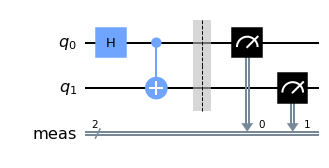

In [4]:
#build the first Bell state
bell1 = qiskit.QuantumCircuit(2)
bell1.h(0)
bell1.cx(0,1)
bell1.measure_all()
bell1.draw("mpl")

The second Bell state we will build is

$$
\frac{|10\rangle + |01\rangle}{\sqrt{2}}
$$

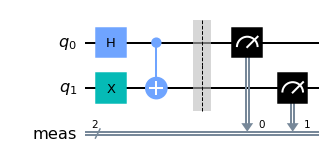

In [3]:
#second Bell state
bell2 = qiskit.QuantumCircuit(2)
bell2.x(1)
bell2.h(0)
bell2.cx(0,1)
bell2.measure_all()
bell2.draw("mpl")

## Noiseless measurement

Now let's do a simple measurement of these circuits. The measurement tool is already included in both circuits, so all we need to do is send these circuits to a noiseless simulator to begin.

In [4]:
#call the Aer noiseless simulator
shots = 2**13
sim = qiskit.Aer.get_backend('aer_simulator')
qc_trans = qiskit.transpile(bell1, sim)
counts = sim.run(qc_trans, shots=shots).result().get_counts()
print('Counts:', counts)

Counts: {'00': 4120, '11': 4072}


As this is a __very__ simple measurement, and we do not even wish to get any probabilities here, only the number of counts for each state of the Bell state, we only see these counts above. However, it is obvious that there are only two states, $|00\rangle$ and $|11\rangle$, the ones we expected. Now let's check the same thing for the second Bell state.

In [5]:
#call the Aer noiseless simulator
qc_trans2 = qiskit.transpile(bell2, sim)
counts2 = sim.run(qc_trans2, shots=shots).result().get_counts()
print('Counts:', counts2)

Counts: {'10': 4052, '01': 4140}


As expected, only the $|10\rangle$ and $|01\rangle$ state have shown up. Now let's move on to the noisy measurement with a noisy backend and see what changes!

## Noisy measurement

We employ the `qiskit.test.mock` module, which uses data from a real IBM quantum device to construct a noisy simulator that will emulate this real quantum computer \[2\]. 

In [6]:
#load qiskit noisy backend (with more than 1 qubit)
noisy_backend = qiskit.test.mock.FakeLondon()
print("Basis gates:", noisy_backend.configuration().basis_gates)
print("Number of qubits:", noisy_backend.configuration().num_qubits)

Basis gates: ['id', 'u1', 'u2', 'u3', 'cx']
Number of qubits: 5


Now let's run our circuits again, on this noisy simulator, and see what we get.

In [7]:
#first Bell state
qc_transn1 = qiskit.transpile(bell1, noisy_backend)
countsn1 = noisy_backend.run(qc_transn1, shots=shots).result().get_counts()
print('Noisy counts for (|00> + |11>):', countsn1)

#second Bell state
qc_transn2 = qiskit.transpile(bell2, noisy_backend)
countsn2 = noisy_backend.run(qc_transn2, shots=shots).result().get_counts()
print('Noisy counts for (|10> + |01>):', countsn2)

Noisy counts for (|00> + |11>): {'11': 3604, '00': 3939, '01': 361, '10': 288}
Noisy counts for (|10> + |01>): {'10': 3732, '01': 3769, '00': 573, '11': 118}


Aha! The counts from the noisy backend clearly show counts in states that are not supposed to be included in the Bell states they correspond to, demonstrating the effect of the noise in a real quantum circuit. This will definitely become an issue with longer and larger computations, and will be something we would like to mitigate. On the next page, we discuss zero-noise extrapolation, a method of error mitigation that we'll be using in future chapters to dispose of as much error as we can while running on real quantum devices.

## References

- \[1\] <tt>mitiq</tt> documentation, "About Error Mitigation," 2020. (Page found [here](https://mitiq.readthedocs.io/en/v.0.1a2/guide/guide_06-error-mitigation.html)).
- \[2\] FRIB-TA Summer School: Quantum Computing and Nuclear Few- and Many-Body Problems, Lecture 11 (link [here](https://github.com/NuclearPhysicsWorkshops/FRIB-TASummerSchoolQuantumComputing/blob/main/doc/pub/lecture11/ipynb/lecture11.ipynb)).